In [1]:
%load_ext autoreload
%autoreload 2
%config Completer.use_jedi = False

In [2]:
import numpy as np

In [3]:
import matplotlib.pyplot as plt
import matplotlib as mpl

mpl.rcParams['mathtext.fontset'] = 'stix'
mpl.rcParams['font.family'] = 'STIXGeneral'
plt.rc('xtick', labelsize=12)
plt.rc('ytick', labelsize=12)
plt.rc('axes', labelsize=12)
mpl.rcParams['figure.dpi'] = 300

In [4]:
from gpax.kernels import RBFKernel
from gpax.gp import ExactGP, VariationalInferenceGP

/Users/mc/miniforge3/envs/py3.12-gpax/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
np.random.seed(0)

NUM_INIT_POINTS = 25     # number of observation points
NOISE_LEVEL = 0.1        # noise level

# Generate noisy data from a known function
f = lambda x: np.sin(10*x)

x = np.random.uniform(-1., 1., NUM_INIT_POINTS)
y = f(x) + np.random.normal(0., NOISE_LEVEL, NUM_INIT_POINTS)
y = y.squeeze()
x = x.reshape(-1, 1)
x_grid = np.linspace(-1.1, 1.1, 1000).reshape(-1, 1)

In [6]:
key = 4

# Exact GP

In [7]:
gp = ExactGP(kernel=RBFKernel(), x=x, y=y, y_std=None, hp_samples=123, gp_samples=456, verbose=True)
gp.fit(key)

sample: 100%|██████████| 2123/2123 [00:01<00:00, 1515.76it/s, 7 steps of size 4.90e-01. acc. prob=0.91]


                mean       std    median      5.0%     95.0%     n_eff     r_hat
  k_length      0.18      0.03      0.18      0.14      0.22     47.04      1.01
   k_noise      0.03      0.02      0.02      0.01      0.05     37.71      1.00
   k_scale      1.26      0.64      1.10      0.39      2.14     62.30      1.02

Number of divergences: 0


In [8]:
samples = gp.sample(key, x_grid)
mean, std = gp.predict(key, x_grid)

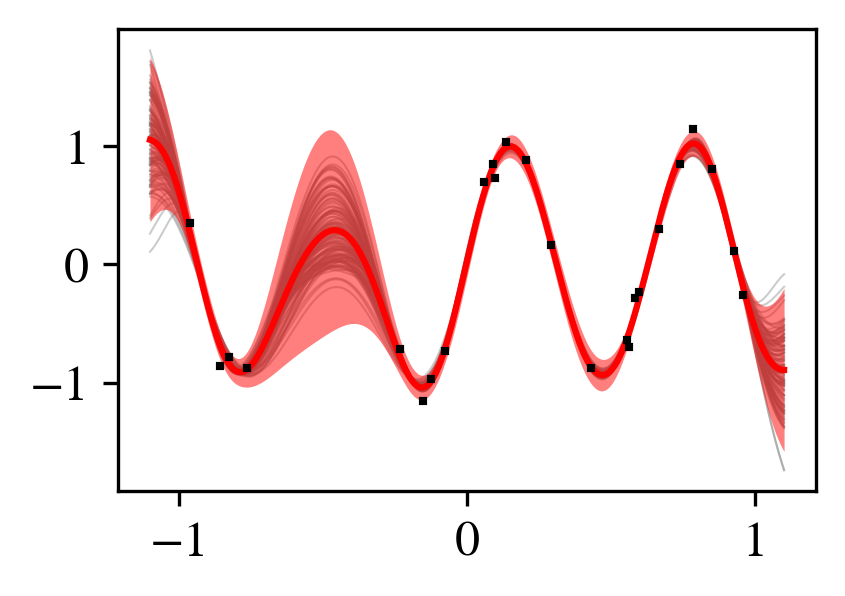

In [10]:
fig, ax = plt.subplots(1, 1, figsize=(3, 2))

plot_kwargs = {
    'linewidth': 0.0,
    'marker': 's',
    'ms': 1.0,
    'capthick': 0.3,
    'capsize': 2.0,
    'elinewidth': 0.3
}

for yy in samples["y"].mean(axis=1):
    ax.plot(x_grid, yy, color="grey", linewidth=0.5, alpha=0.4)
    # break


ax.errorbar(x, y, yerr=gp.y_std if gp.y_std is not None else None, color="black", zorder=3, **plot_kwargs)
ax.plot(x_grid, mean, "r-")
ax.fill_between(x_grid.squeeze(), mean - std, mean + std, color="red", alpha=0.5, linewidth=0, zorder=3)

plt.show()

# Simple acquisition function test

In [29]:
from gpax.acquisition import UpperConfidenceBound, ExpectedImprovement

In [30]:
bounds = np.array([-1.1, 1.1]).reshape(-1, 1)

## EI

In [31]:
mc_samples = 1000
acqf = ExpectedImprovement(q=1, bounds=bounds, verbose=1)
x_star, y_star = acqf.optimize(key, gp, n=mc_samples, method="Halton")
print(x_star)
acqf = ExpectedImprovement(q=2, bounds=bounds, verbose=1)
x_star, y_star = acqf.optimize(key, gp, n=mc_samples, method="Halton")
print(x_star)

qmc discrepancy (sample quality index) = 4.86e-07


100%|██████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.91it/s]


[[-1.09867695]]
qmc discrepancy (sample quality index) = 2.01e-06


100%|██████████████████████████████████████████████████████████████████| 10/10 [00:02<00:00,  4.83it/s]


[[ 0.19468242]
 [-1.09094782]]


## UCB

In [32]:
mc_samples = 1000
acqf = UpperConfidenceBound(beta=np.inf, q=1, bounds=bounds, verbose=1)
x_star, y_star = acqf.optimize(2, gp, n=mc_samples, method="Halton")
print(x_star)
acqf = UpperConfidenceBound(beta=np.inf, q=2, bounds=bounds, verbose=1)
x_star, y_star = acqf.optimize(2, gp, n=mc_samples, method="Halton")
print(x_star)

qmc discrepancy (sample quality index) = 1.01e-06


100%|██████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.82it/s]


[[-0.48751662]]
qmc discrepancy (sample quality index) = 3.48e-06


100%|██████████████████████████████████████████████████████████████████| 10/10 [00:02<00:00,  4.83it/s]

[[ 1.09373338]
 [-0.54127881]]


# VI GP

In [8]:
gp = VariationalInferenceGP(kernel=RBFKernel(), x=x, y=y, y_std=None, num_steps=10000)
gp.fit(key)

In [9]:
samples = gp.sample(key, x_grid)
mean, std = gp.predict(key, x_grid)

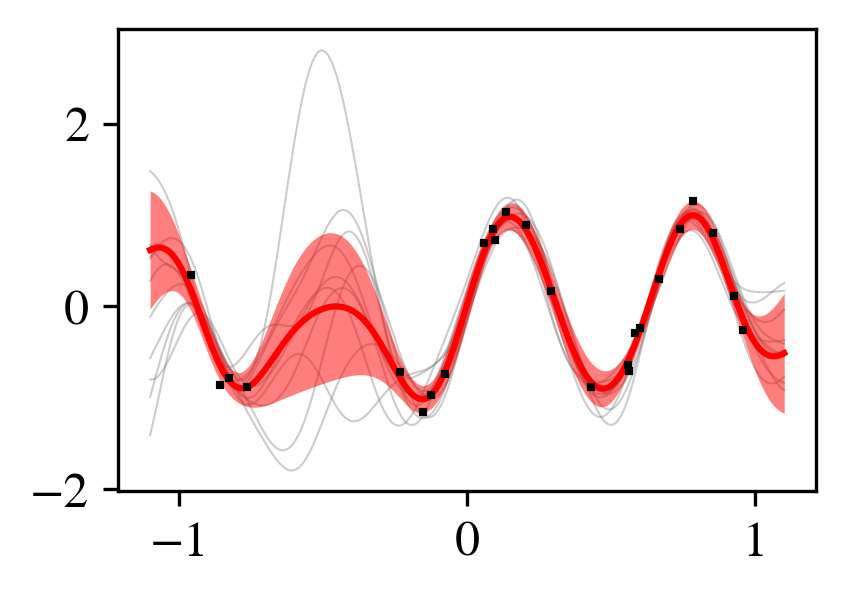

In [20]:
fig, ax = plt.subplots(1, 1, figsize=(3, 2))

plot_kwargs = {
    'linewidth': 0.0,
    'marker': 's',
    'ms': 1.0,
    'capthick': 0.3,
    'capsize': 2.0,
    'elinewidth': 0.3
}

for yy in samples["y"].squeeze():
    ax.plot(x_grid, yy, color="grey", linewidth=0.5, alpha=0.4)
    # break

ax.errorbar(gp.x, gp.y, yerr=gp.y_std if gp.y_std is not None else None, color="black", zorder=3, **plot_kwargs)
ax.plot(x_grid, mean, "r-")
ax.fill_between(x_grid.squeeze(), mean - std, mean + std, color="red", alpha=0.5, linewidth=0, zorder=3)




plt.show()